<a href="https://colab.research.google.com/github/Aleksandr62aa/Test_task/blob/main/FC_NN_diabetes_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Classification of Diabetes**

**Dataset Diabetes**

**Importing libraries**

In [224]:
!pip install torchinfo

In [381]:
import torch
import random
from torchinfo import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.datasets
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import csv
import cv2
from tqdm import tqdm

# Fixed seed
random.seed(9)
np.random.seed(9)
torch.manual_seed(9)
torch.cuda.manual_seed(9)
torch.backends.cudnn.deterministic = True

In [382]:
# Hyperparameters

# Training
num_epochs = 200
learning_rate = 1.0e-3

# Dataset
train_ratio = 0.8

# Model
input_size = 8
n_hidden_1 = 64
n_hidden_2 = 32
n_hidden_3 = 16
classes = 2

**Train Test dataset**

In [383]:
class CustomDataset(Dataset):
    def __init__(self, tile_name):
        # read csv file
        file_out = pd.read_csv(tile_name)
        x = file_out.iloc[:,:-1].values
        y = file_out.iloc[:,-1].values

        # Applying StandardScaler
        scaler = StandardScaler()
        x_scaler = scaler.fit_transform(x)

        # converting to torch tensors
        self.X = torch.tensor(x_scaler, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int64)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [384]:
dataset = CustomDataset('diabetes.csv')

In [385]:
# Define Split Ratios
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

In [386]:
print(len(train_data), len(test_data))
print(train_data[0], test_data[0])

614 154
(tensor([-0.8449, -0.3723, -0.4707, -0.7864,  0.8874, -0.8367,  1.4349, -1.0415]), tensor(0)) (tensor([-1.1419, -0.6539,  0.0462,  0.3427, -0.2587, -0.1514,  0.3779, -1.0415]), tensor(0))


In [387]:
train_dataloader = DataLoader(train_data, batch_size=len(train_data), shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [388]:
for batch in train_dataloader :
    X_batch, y_batch = batch
    print( y_batch.sum())


tensor(202)


In [389]:
print(len(train_data), len(train_dataloader))
print(len(test_data), len(test_dataloader))

614 1
154 1


In [390]:
# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

**Model FC NN**

In [391]:
class DiabedNet(torch.nn.Module):
    def __init__(self, input_size):
        # super().__init__()
        super(DiabedNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, n_hidden_1)
        self.fc2 = torch.nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = torch.nn.Linear(n_hidden_2, n_hidden_3)
        self.fc4 = torch.nn.Linear(n_hidden_3, classes)
        self.relu = torch.nn.ReLU()
        # self.drop_out = torch.nn.Dropout(p=0.2)


    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

model = DiabedNet(input_size).to(device)

In [392]:
# model

In [393]:
summary(model, input_size=(1, 8))

Layer (type:depth-idx)                   Output Shape              Param #
DiabedNet                                [1, 2]                    --
├─Linear: 1-1                            [1, 64]                   576
├─ReLU: 1-2                              [1, 64]                   --
├─Linear: 1-3                            [1, 32]                   2,080
├─ReLU: 1-4                              [1, 32]                   --
├─Linear: 1-5                            [1, 16]                   528
├─ReLU: 1-6                              [1, 16]                   --
├─Linear: 1-7                            [1, 2]                    34
Total params: 3,218
Trainable params: 3,218
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

**Loss function**

In [394]:
class_weights = torch.tensor([0.3, 0.7])  # веса
# class_weights = torch.tensor([1, 1])
loss = torch.nn.CrossEntropyLoss(class_weights)

# loss = torch.nn.CrossEntropyLoss()

**Optimizer**

In [395]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**Training procedure**

In [396]:
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

for epoch in tqdm(range(num_epochs)):   # цикл обучения по эпохам

    running_loss_train = 0.
    running_acc_train = 0.
    model.train()

    for batch in train_dataloader:# цикл обучения по бачам

        optimizer.zero_grad()
        X_batch, y_batch = batch

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_preds = model.forward(X_batch)

        # loss функция
        loss_train = loss(y_preds, y_batch)

        loss_train.backward()
        optimizer.step()
        running_loss_train += loss_train.cpu().detach().numpy()
        running_acc_train += (y_preds.argmax(dim=1) == y_batch).float().mean().cpu().detach().numpy()
    epoch_loss = running_loss_train/ len(train_dataloader)
    train_loss_history.append(epoch_loss)

    epoch_acc = running_acc_train/len(train_dataloader)
    train_accuracy_history .append(epoch_acc)

    # тестирование модели
    running_loss_test = 0.
    running_acc_test = 0.
    model.eval()

    for batch in test_dataloader:
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_preds = model.forward(X_batch)

        running_loss_test += loss(y_preds, y_batch).cpu().detach().numpy()
        running_acc_test += (y_preds.argmax(dim=1) == y_batch).float().mean().cpu().detach().numpy()

    epoch_loss = running_loss_test/len(test_dataloader)
    test_loss_history.append(epoch_loss)

    epoch_acc = running_acc_test/len(test_dataloader)
    test_accuracy_history.append(epoch_acc)


100%|██████████| 200/200 [00:02<00:00, 77.25it/s]


In [240]:
# # Evaluate the model using PyTorch

# y_true = []
# y_pred = []
# model.eval()

# for batch in test_dataloader:
#     X_batch, y_batch = batch
#     X_batch = X_batch.to(device)
#     outputs = model(X_batch)
#     _, y_preds = torch.max(outputs, dim=1)
#     y_pred.extend(y_preds.cpu().numpy())
#     y_true.extend(y_batch.cpu().numpy())

# # Convert lists to tensors for calculation
# y_true_tensor = torch.tensor(y_true)
# y_pred_tensor = torch.tensor(y_pred)

# # Calculating precision, recall, and F1 score using PyTorch
# TP = ((y_pred_tensor == 1) & (y_true_tensor == 1)).sum().item()
# TN = ((y_pred_tensor == 0) & (y_true_tensor == 0)).sum().item()
# FP = ((y_pred_tensor == 1) & (y_true_tensor == 0)).sum().item()
# FN = ((y_pred_tensor == 0) & (y_true_tensor == 1)).sum().item()

# accuracy = (TP + TN) / (TP + TN + FP + FN) if TP + TN + FP + FN > 0 else 0

# precision_0 = TN / (TN + FN) if TN + FN > 0 else 0
# precision_1 = TP / (TP + FP) if TP + FP > 0 else 0
# recall_0 = TN / (TN + FP) if TN + FP > 0 else 0
# recall_1 = TP / (TP + FN) if TP + FN > 0 else 0

# f1_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
# f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0

# print(f'Accuracy: {accuracy:.4f}')
# print(f'Precision_0: {precision_0:.4f}, Precision_1: {precision_1:.4f}')
# print(f'Recall_0: {recall_0:.4f}, Recall_1: {recall_1:.4f}')
# print(f'F1-Score_0: {f1_0:.4f}, F1-Score_1: {f1_1:.4f}')

In [397]:
y_true = []
y_pred = []
model.eval()

for batch in test_dataloader:
    X_batch, y_batch = batch
    X_batch = X_batch.to(device)
    outputs = model(X_batch)
    _, y_preds = torch.max(outputs, dim=1)
    y_pred.extend(y_preds.cpu().detach().numpy())
    y_true.extend(y_batch.cpu().detach().numpy())

print(f'Accuracy: {accuracy_score(y_true, y_pred):.4f}')
print(f'\nClassification Report:\n {classification_report(y_true, y_pred)}')

Accuracy: 0.7792

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81        88
           1       0.76      0.71      0.73        66

    accuracy                           0.78       154
   macro avg       0.78      0.77      0.77       154
weighted avg       0.78      0.78      0.78       154



**Result test**

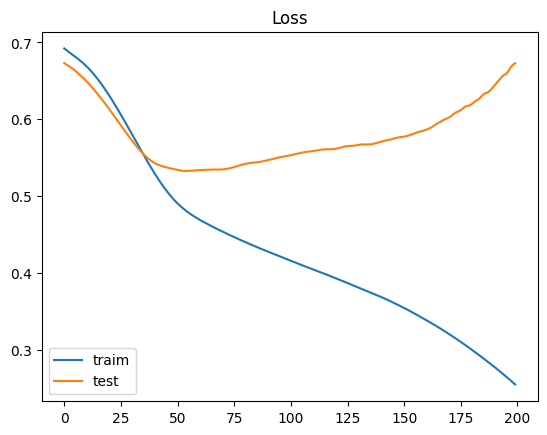

In [398]:
plt.plot(train_loss_history, label='traim')
plt.plot(test_loss_history, label='test')
plt.legend(loc='best')
plt.title('Loss');

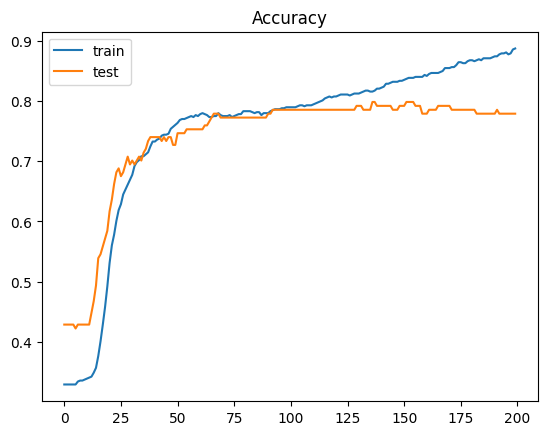

In [399]:
plt.plot(train_accuracy_history, label='train')
plt.plot(test_accuracy_history, label='test')
plt.legend(loc='best')
plt.title('Accuracy');

In [ ]:
# Save the model state
st = model.state_dict()
torch.save(st, 'diab_net.tar')
# torch.save(st, 'mnist_net.pth')

In [ ]:
# mnist_net.fc1.weight.data, mnist_net.fc1.bias.data

In [ ]:
##########################################################33